# 概要

- PyCWT(v0.3.0a22)の[Tutorial](http://pycwt.readthedocs.io/en/latest/tutorial.html)を参考に、Niño 3 SST Indexのデータのウェーブレットパワースペクトルを可視化していく。


# 下準備

- ライブラリを読み込む。
- 分析対象データをダウンロードする。
- メタデータを設定しておく。

## ライブラリの読み込み

- ローカルで[pycwt](http://pycwt.readthedocs.io/en/latest/)ライブラリをインストールしてから、以下のライブラリを読み込む。

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pycwt as wavelet
from pycwt.helpers import find

## 分析対象データの読み込み

- Niño 3 SST Indexよりデータをダウンロードする。

In [2]:
url = 'http://paos.colorado.edu/research/wavelets/wave_idl/nino3sst.txt'
dat = np.genfromtxt(url, skip_header=19)

## メタデータの設定

- 分析対象データのメタデータを設定しておく。

In [3]:
title = 'NINO3 Sea Surface Temperature'
label = 'NINO3 SST'
units = 'degC'

In [4]:
# 初年
t0 = 1871.0
# 区切り
dt = 0.25

# 前処理

## 時間データの生成

In [5]:
N = dat.size
t = np.arange(0, N) * dt + t0

## 分析対象データの整形

- トレンド除去と正規化を行なう。
- しばしばトレンド除去は不要であると見做される。しかし、Mauna Loa CO2のデータセットなどのように、トレンドによって特徴付けられているデータを分析する場合はこの限りではない。

In [6]:
p = np.polyfit(t - t0, dat, 1)
dat_notrend = dat - np.polyval(p, t - t0)
# 標準偏差
std = dat_notrend.std()
# 分散
var = std ** 2
# 正規化
dat_norm = dat_notrend / std

## ウェーブレット解析のパラメタ設定

- マザーウェーブレットを選択する。
- ここでは $w_0 = 6$ のモルレーウェーブレットを利用する。

In [7]:
mother = wavelet.Morlet(6)
s0 = 2 * dt
dj = 1 / 12
J = 7 / dj
alpha, _, _ = wavelet.ar1(dat)  # Lag-1 autocorrelation for red noise

# ウェーブレット解析

## ウェーブレット変換と逆ウェーブレット変換

- 上述したパラメタを参照することで、ウェーブレット変換と逆ウェーブレット変換を実行する。
- 入力データの時系列を正規化する都合上、逆変換結果には標準偏差を掛けておく。

In [8]:
wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(dat_norm, dt, dj, s0, J, mother)
iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std

## ウェーブレットパワースペクトルとフーリエパワースペクトルの算出

- 正規化されたウェーブレットパワースペクトルとフーリエパワースペクトルを計算する。
- 周波数から周期も計算しておく。

In [10]:
power = (np.abs(wave)) ** 2
fft_power = np.abs(fft) ** 2
period = 1 / freqs

### ウェーブレットパワースペクトルの規格化

- iu et al. (2007)で提案されている方法により、ウェーブレットパワースペクトルを規格化しておく。
- ただしこれはデータの整形方法の一種に過ぎない。

In [11]:
power /= scales[:, None]

# 検証

## パワースペクトルの有意性検証

- 95%信頼区間で有意性を検証する。
    - つまり、`power / sig95 > 1` を満たすパワーが有意となる。

In [13]:
signif, fft_theor = wavelet.significance(1.0, dt, scales, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig95 = np.ones([1, N]) * signif[:, None]
sig95 = power / sig95

## グローバルウェーブレットスペクトルとその有意性の算出

- グローバルウェーブレットスペクトルとその有意性も計算する。

In [14]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correction for padding at edges
glbl_signif, tmp = wavelet.significance(
    var,
    dt,
    scales,
    1,
    alpha,
    significance_level=0.95,
    dof=dof,
    wavelet=mother
)

## スケールの平均値とその有意性の算出

- 2年から8年までの間のスケールの平均値とその有意性を計算する。

In [15]:
sel = find((period >= 2) & (period < 8))
Cdelta = mother.cdelta
scale_avg = (scales * np.ones((N, 1))).transpose()
scale_avg = power / scale_avg  # As in Torrence and Compo (1998) equation 24
scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
scale_avg_signif, tmp = wavelet.significance(
    var,
    dt,
    scales,
    2,
    alpha,
    significance_level=0.95,
    dof=[scales[sel[0]],
         scales[sel[-1]]],
    wavelet=mother
)

## ウェーブレット解析結果の可視化

- 原信号の生ログを時系列でプロットする(a)。
- ウェーブレットパワースペクトルをプロットする(b)。
- グローバルウェーブレットとフーリエスペクトルをプロットする(c)。
- ウェーブレットスペクトルの平均値の範囲をプロットする(d)。

/usr/local/bin/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


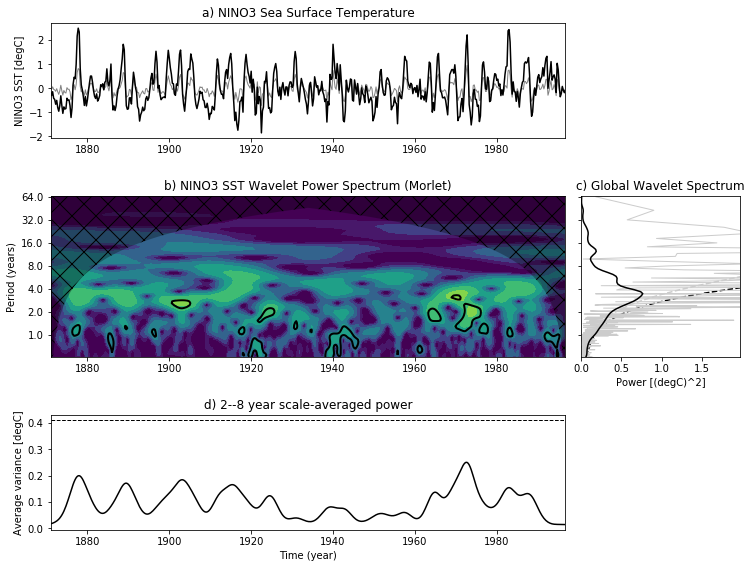

In [18]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

plt.show()

### 予備考察：ウェーブレットパワースペクトルの最大値や平均値の推移を遡及する

- 側頭葉てんかん発作の脳波、歯車や軸受などのようなマシンの故障時の振動データ、あるいは単に超音波を解析する場合などは、ウェーブレットパワースペクトルの最大値や平均値の時系列的な変化を辿るユースケースもあり得る。
- そこで以下のように、サンプルコードを改修することで可視化してみる。

/usr/local/bin/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


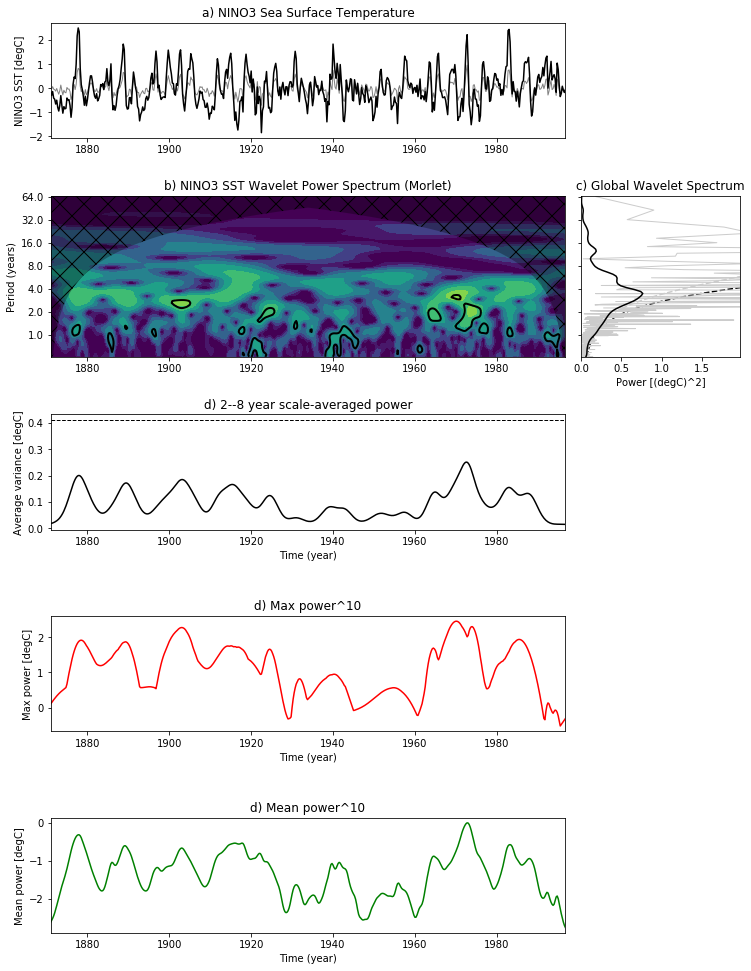

In [19]:
# Prepare the figure
plt.close('all')
plt.ioff()
figprops = dict(figsize=(11, 8), dpi=72)
fig = plt.figure(**figprops)

# First sub-plot, the original time series anomaly and inverse wavelet
# transform.
ax = plt.axes([0.1, 0.75, 0.65, 0.2])
ax.plot(t, iwave, '-', linewidth=1, color=[0.5, 0.5, 0.5])
ax.plot(t, dat, 'k', linewidth=1.5)
ax.set_title('a) {}'.format(title))
ax.set_ylabel(r'{} [{}]'.format(label, units))

# Second sub-plot, the normalized wavelet power spectrum and significance
# level contour lines and cone of influece hatched area. Note that period
# scale is logarithmic.
bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels),
            extend='both', cmap=plt.cm.viridis)
extent = [t.min(), t.max(), 0, max(period)]
bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                           t[:1] - dt, t[:1] - dt]),
        np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                           np.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
bx.set_ylabel('Period (years)')
#
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                           np.ceil(np.log2(period.max())))
bx.set_yticks(np.log2(Yticks))
bx.set_yticklabels(Yticks)

# Third sub-plot, the global wavelet and Fourier power spectra and theoretical
# noise spectra. Note that period scale is logarithmic.
cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
cx.plot(glbl_signif, np.log2(period), 'k--')
cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
        linewidth=1.)
cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
cx.set_title('c) Global Wavelet Spectrum')
cx.set_xlabel(r'Power [({})^2]'.format(units))
cx.set_xlim([0, glbl_power.max() + var])
cx.set_ylim(np.log2([period.min(), period.max()]))
cx.set_yticks(np.log2(Yticks))
cx.set_yticklabels(Yticks)
plt.setp(cx.get_yticklabels(), visible=False)

# Fourth sub-plot, the scale averaged wavelet spectrum.
dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
dx.plot(t, scale_avg, 'k-', linewidth=1.5)
dx.set_title('d) {}--{} year scale-averaged power'.format(2, 8))
dx.set_xlabel('Time (year)')
dx.set_ylabel(r'Average variance [{}]'.format(units))
ax.set_xlim([t.min(), t.max()])

ex = plt.axes([0.1, 0.07 - 0.35, 0.65, 0.2], sharex=ax)
ex.plot(t, np.log2(power.max(axis=0)), 'red', linewidth=1.5)
ex.set_title('d) Max power^10')
ex.set_xlabel('Time (year)')
ex.set_ylabel(r'Max power [{}]'.format(units))
ex.set_xlim([t.min(), t.max()])

fx = plt.axes([0.1, 0.07 - 0.35 - 0.35, 0.65, 0.2], sharex=ax)
fx.plot(t, np.log2(power.mean(axis=0)), 'green', linewidth=1.5)
fx.set_title('d) Mean power^10')
fx.set_xlabel('Time (year)')
fx.set_ylabel(r'Mean power [{}]'.format(units))
fx.set_xlim([t.min(), t.max()])


plt.show()

## 参考資料

- http://pycwt.readthedocs.io/en/latest/tutorial.html?highlight=wavelet.cwt
- Torrence, C. and Compo, G. P.. A Practical Guide to Wavelet Analysis. Bulletin of the American Meteorological Society, American Meteorological Society, 1998, 79, 61-78.
- Liu, Y., Liang, X. S. and Weisberg, R. H. Rectification of the bias in the wavelet power spectrum. Journal of Atmospheric and Oceanic Technology, 2007, 24, 2093-2102. 